In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(iris_X, iris_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = iris_X[:, 0], iris_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=iris_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [3]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

In [4]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [5]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

# [Бустинг](https://ru.wikipedia.org/wiki/%D0%91%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3_(%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD))

Изначально метод бустинга (от hypothesis boosting - усиление гипотезы) - это любой ансамблевый метод, который способен комбинировать несколько "слабых моделей" в одну "сильную модель". 

Сейчас термин "бустинг", как правило, ассоциируется с алгоритмом градиентного бустинга.

В отличие от методов бэггинга и случайного леса, которые **ориентированы прежде всего на минимизизацию дисперсии (Variance)**, методы бустинга **ориентированы прежде всего на минимизацию смещения (Bias) и, отчасти, на минимизизацию дисперсии.**

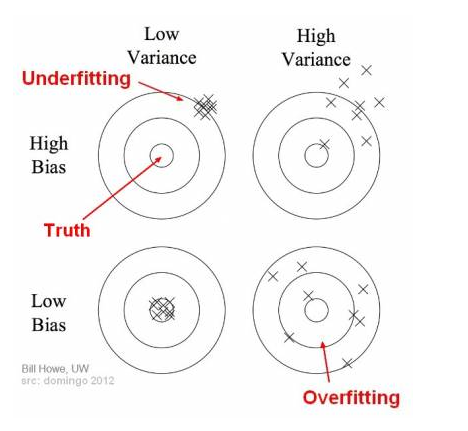

In [6]:
Image('img/bv1.png', width='30%')

Различие между бэггингом и бустингом показано на следющем рисунке:

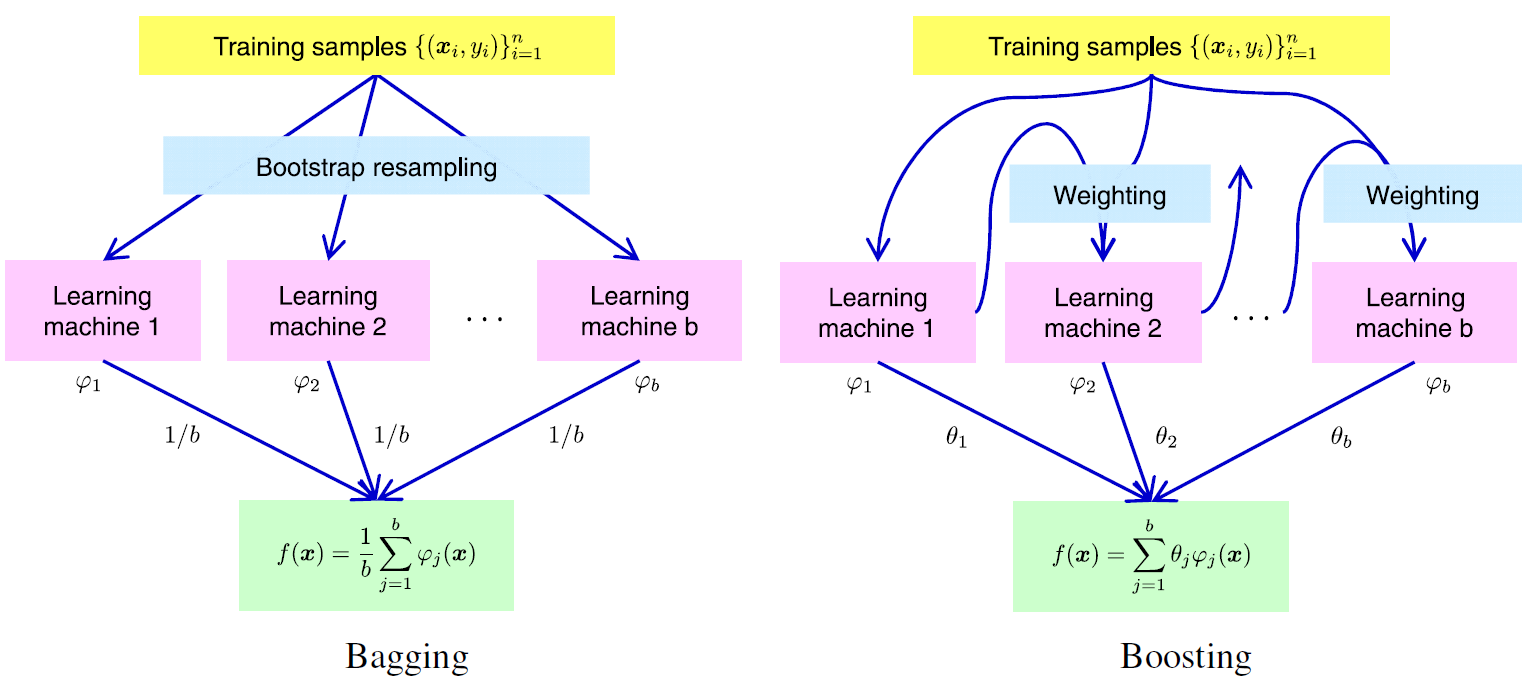

In [7]:
Image('img/boosting.png', width='70%')

**Бустинг может рассматриваться как разновидность линейной регресии, где регрессорами являются выходы "слабых моделей".**

Также идея метода отчасти напоминает идею нейронной сети, но в качестве "нейрона" обычно используется решающее дерево (хотя может использоваться произвольная модель).

## Алгоритм AdaBoost

Исторически первым полноценным алгоритмом бустинга считается алгоритм [AdaBoost.](https://ru.wikipedia.org/wiki/AdaBoost) 

[Статья авторов с пояснением метода.](http://www.site.uottawa.ca/~stan/csi5387/boost-tut-ppr.pdf)

[Презентация 1](https://mycourses.aalto.fi/pluginfile.php/901916/mod_folder/content/0/Boosting.pdf) и [Презентация 2](http://cmp.felk.cvut.cz/~sochmj1/adaboost_talk.pdf) с пояснением работы метода ([локальная копия презентации 1](materials/boosting.pdf)). 

Схема обучения представлена в [описании метода](https://ru.wikipedia.org/wiki/AdaBoost) и в [презентации 1.](materials/boosting.pdf)

AdaBoost реализуется в scikit-learn с помощью классов [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) и [AdaBoostRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

В библиотеке scikit-learn реализован многоклассовый вариант алгоритма AdaBoost - [алгоритм SAMME.](https://web.stanford.edu/~hastie/Papers/samme.pdf) (Stagewise Additive Modeling using a Multiclass Exponential loss function - ступенчатое аддитивное моделирование с применением многоклассовой экспоненциальной функции потерь). Модификация этого алгоритма, которая предсказывает не только классы, но и вероятности классов называется "SAMME.R".

### Эксперименты с реализацией scikit-learn:

In [8]:
# Используем датасет iris с двумя первыми признаками
iris = load_iris()
iris_X = iris.data[:, :2]
iris_y = iris.target

In [9]:
# Обучим классификатор на 5 деревьях
ab1 = AdaBoostClassifier(n_estimators=5, algorithm='SAMME', random_state=10)
ab1.fit(iris_X, iris_y)

AdaBoostClassifier(algorithm='SAMME', n_estimators=5, random_state=10)

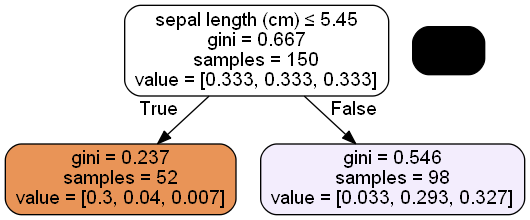

In [10]:
Image(get_png_tree(ab1.estimators_[0], iris.feature_names[:2]), width='40%')

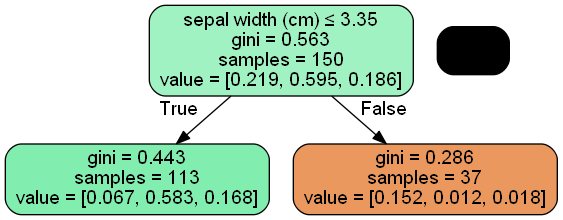

In [11]:
Image(get_png_tree(ab1.estimators_[1], iris.feature_names[:2]), width='40%')

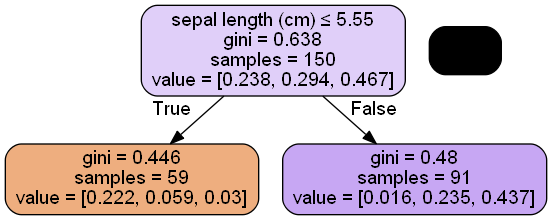

In [12]:
Image(get_png_tree(ab1.estimators_[2], iris.feature_names[:2]), width='40%')

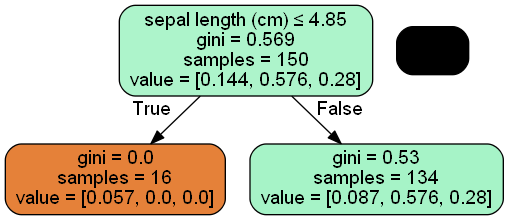

In [13]:
Image(get_png_tree(ab1.estimators_[3], iris.feature_names[:2]), width='40%')

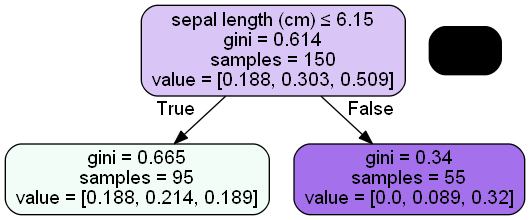

In [14]:
Image(get_png_tree(ab1.estimators_[4], iris.feature_names[:2]), width='40%')

Веса деревьев в ансамбле соответствуют параметру $\alpha_t$:

In [15]:
ab1.estimator_weights_

array([1.21109027, 1.71357397, 1.35360531, 1.24138009, 0.83110679])

Метод decision_function(X) возвращает итоговое значение матрицы $D_t$:

In [16]:
df1 = ab1.decision_function(iris_X)
df1.shape

(150, 3)

In [17]:
df1[:10]

array([[0.67366299, 0.32633701, 0.        ],
       [0.40384096, 0.59615904, 0.        ],
       [0.5993106 , 0.4006894 , 0.        ],
       [0.5993106 , 0.4006894 , 0.        ],
       [0.67366299, 0.32633701, 0.        ],
       [0.67366299, 0.32633701, 0.        ],
       [0.86913263, 0.13086737, 0.        ],
       [0.67366299, 0.32633701, 0.        ],
       [0.5993106 , 0.4006894 , 0.        ],
       [0.40384096, 0.59615904, 0.        ]])

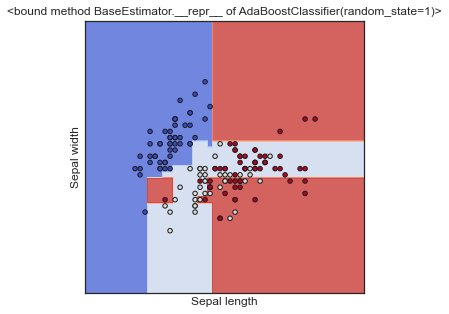

In [18]:
# Результаты классификации
plot_cl(AdaBoostClassifier(random_state=1))

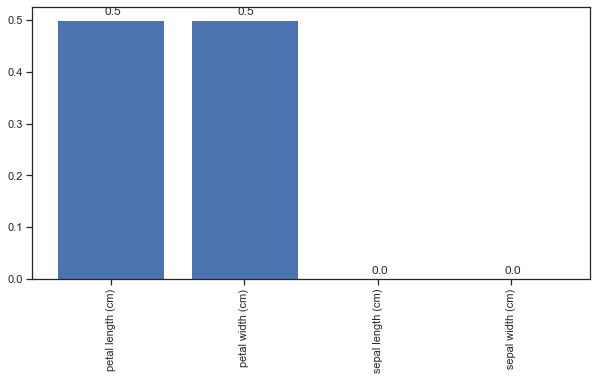

In [19]:
# Важность признаков
iris_x_ds = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
ab2 = AdaBoostClassifier(random_state=1)
ab2.fit(iris_x_ds, iris.target)
_,_ = draw_feature_importances(ab2, iris_x_ds)

В настоящее время алгоритм AdaBoost считается устаревшим и вместо него используется:

## Алгоритм [градиентного бустинга](https://en.wikipedia.org/wiki/Gradient_boosting)

Идея градиентного бустинга состоит в том, что строится многослойная модель (классификации или регрессии) и каждый следующий слой пытается минимизировать остаточную ошибку (residual error), допущенную на предыдущем слое.

Каждый следующий слой учится на ошибку (невязку) между предыдущим слоем и истинным значением.

[Краткое введение в градиентный бустинг.](https://neurohive.io/ru/osnovy-data-science/gradientyj-busting/)

[Блог Александра Дьяконова. Градиентный бустинг](https://dyakonov.org/2017/06/09/%d0%b3%d1%80%d0%b0%d0%b4%d0%b8%d0%b5%d0%bd%d1%82%d0%bd%d1%8b%d0%b9-%d0%b1%d1%83%d1%81%d1%82%d0%b8%d0%bd%d0%b3/)

Основные принципы градиентного бустинга изложены в [математическом описании реализации scikit-learn.](https://scikit-learn.org/stable/modules/ensemble.html#mathematical-formulation)

Необходимо отметить, что в случае задачи классификации, для слоев все равно решается задача регресии для вероятностей классов.

### Реализации градиентного бустинга

Рассмотрены в статьях:
- https://blog.mattbowers.dev/gradient-boosting-machine-from-scratch 

Градиентный бустинг реализуется в scikit-learn с помощью классов [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) и [GradientBoostingRegressor.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) Но эта реализация считается неэффективной.

Традиционно вместо нее использовалась библиотека [XGBoost.](https://github.com/dmlc/xgboost)

В последнее время также активно используется библиотека [LightGBM.](https://github.com/Microsoft/LightGBM) Статья о [настройке гиперпараметров.](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

Наиболее новой и перспективной является библиотека от Яндекса [CatBoost.](https://tech.yandex.ru/catboost/)

### Эксперименты с реализацией scikit-learn:

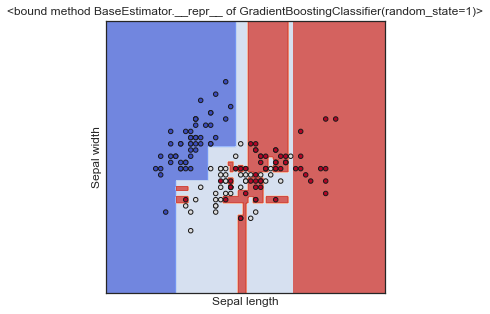

In [20]:
plot_cl(GradientBoostingClassifier(random_state=1))

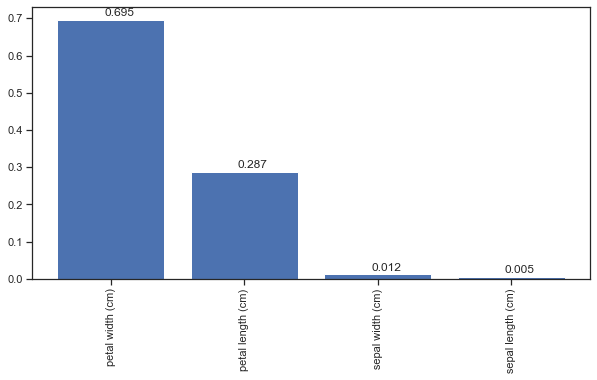

In [21]:
# Важность признаков
iris_gb_cl = GradientBoostingClassifier(random_state=1)
iris_gb_cl.fit(iris_x_ds, iris.target)
_,_ = draw_feature_importances(iris_gb_cl, iris_x_ds)

# Дополнительные источники
- [Открытый курс машинного обучения. Тема 10. Градиентный бустинг](https://habr.com/ru/company/ods/blog/327250/)
- [Блог Александра Дьяконова. Ансамбли в машинном обучении](https://dyakonov.org/2019/04/19/%d0%b0%d0%bd%d1%81%d0%b0%d0%bc%d0%b1%d0%bb%d0%b8-%d0%b2-%d0%bc%d0%b0%d1%88%d0%b8%d0%bd%d0%bd%d0%be%d0%bc-%d0%be%d0%b1%d1%83%d1%87%d0%b5%d0%bd%d0%b8%d0%b8/)
- [Блог Александра Дьяконова. Градиентный бустинг](https://dyakonov.org/2017/06/09/%d0%b3%d1%80%d0%b0%d0%b4%d0%b8%d0%b5%d0%bd%d1%82%d0%bd%d1%8b%d0%b9-%d0%b1%d1%83%d1%81%d1%82%d0%b8%d0%bd%d0%b3/)

**Статьи**

- http://www.site.uottawa.ca/~stan/csi5387/boost-tut-ppr.pdf
- https://medium.com/diogo-menezes-borges/boosting-with-adaboost-and-gradient-boosting-9cbab2a1af81
- https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db
